<a href="https://colab.research.google.com/github/Waltberry/Tweet-Emotion-Recognition/blob/main/Tweet_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

---

## Introduction


## Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [2]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 9.6 MB/s 
     |████████████████████████████████| 212 kB 74.2 MB/s 


In [3]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.2


## Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [4]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [5]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [6]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [7]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [8]:
tweets, labels = get_tweets(train)

In [11]:
tweets[10], labels[10]

('i feel like i have to make the suffering i m seeing mean something',
 'sadness')

## Tokenizer

1. Tokenizing the tweets

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [14]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

In [16]:
print(tokenizer.texts_to_sequences([tweets[10]]))

[[2, 3, 14, 2, 21, 5, 80, 6, 733, 2, 93, 544, 304, 84]]


In [17]:
tweets[10]

'i feel like i have to make the suffering i m seeing mean something'

## Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

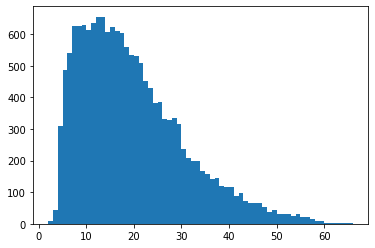

In [18]:
# Showing the distribution of lenths of tweet in the tweets
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [20]:
maxlen = 50

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [21]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=maxlen, padding='post')
    return padded_sequences

In [22]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [24]:
padded_train_sequences[10]

array([  2,   3,  14,   2,  21,   5,  80,   6, 733,   2,  93, 544, 304,
        84,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Preparing the Labels

- approach used in mult-class classifications, having numeric values for the different classes.
1. Creating classes to index and index to classes dictionaries 
2. Converting text labels to numeric labels

In [25]:
classes = set(labels)
print(classes)

{'joy', 'surprise', 'sadness', 'love', 'fear', 'anger'}


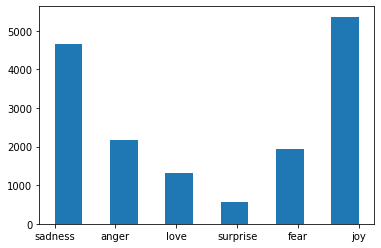

In [26]:
plt.hist(labels, bins=11)
plt.show()

# class inbalance problem, but it is ok, we will not worry about it here.

In [33]:
# convert classes to their numeric value
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [34]:
class_to_index

{'joy': 0, 'surprise': 1, 'sadness': 2, 'love': 3, 'fear': 4, 'anger': 5}

In [35]:
index_to_class

{0: 'joy', 1: 'surprise', 2: 'sadness', 3: 'love', 4: 'fear', 5: 'anger'}

In [36]:
# names to numeric values
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [41]:
train_labels = names_to_ids(labels)
print(train_labels[0])

2


## Creating the Model

1. Creating the model
2. Compiling the model

In [42]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Training the Model

1. Preparing a validation set
2. Training the model

In [43]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [45]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 2)

In [46]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2) # if no improvement in validation accuracy for over 2 epoch, it will stop
    ]
)

Epoch 1/20
500/500 [==============================] - 17s 16ms/step - loss: 1.3348 - accuracy: 0.4835 - val_loss: 0.8666 - val_accuracy: 0.6990
Epoch 2/20
500/500 [==============================] - 6s 12ms/step - loss: 0.6108 - accuracy: 0.7856 - val_loss: 0.5799 - val_accuracy: 0.8005
Epoch 3/20
500/500 [==============================] - 6s 12ms/step - loss: 0.3394 - accuracy: 0.8932 - val_loss: 0.4677 - val_accuracy: 0.8535
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2168 - accuracy: 0.9335 - val_loss: 0.4146 - val_accuracy: 0.8700
Epoch 5/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1581 - accuracy: 0.9549 - val_loss: 0.4444 - val_accuracy: 0.8725
Epoch 6/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1233 - accuracy: 0.9641 - val_loss: 0.4245 - val_accuracy: 0.8765
Epoch 7/20
500/500 [==============================] - 6s 12ms/step - loss: 0.0970 - accuracy: 0.9706 - val_loss: 0.4444 - val_accuracy: 0.877

## Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

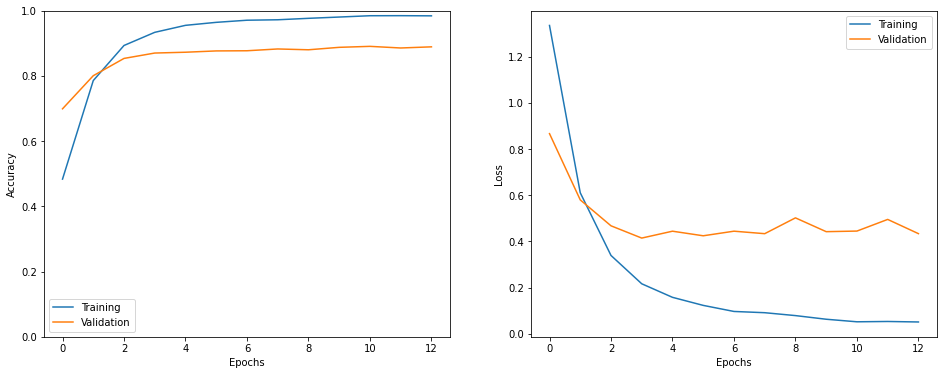

In [49]:
show_history(h) # function is above in Setup and Imports cell

In [48]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [50]:
_ = model.evaluate(test_sequences, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.4820 - accuracy: 0.8735


In [55]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = np.argmax(model.predict(np.expand_dims(test_sequences[i], axis=0))[0])

print('Predicted Emotion:', index_to_class.get(p))

Sentence: i want each of you to feel my gentle embrace
Emotion: love
Predicted Emotion: love


In [67]:
# predict_x=model.predict(X_test) 
# classes_x=np.argmax(predict_x,axis=1)
preds = np.argmax(model.predict(test_sequences), axis=1)
preds.shape, test_labels.shape

((2000,), (2000,))

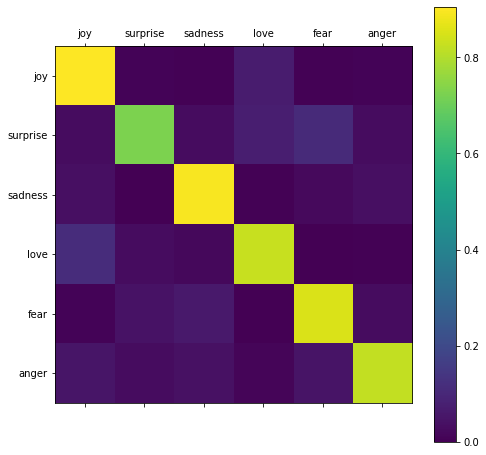

In [68]:
show_confusion_matrix(test_labels, preds, list(classes))